## Data Analysis for Sleep dataset

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

Data loading and cleaning

In [11]:
# 1) Read the CSV
input_path = "HUAMI_EXTENDED_ACTIVITY_SAMPLE_202510311056.csv"  # change if needed
df = pd.read_csv(input_path)

# 2) Convert Unix timestamp (seconds) -> readable datetime
# If your timestamp is seconds since epoch (as you described), unit="s" is correct.
df["datetime"] = pd.to_datetime(df["TIMESTAMP"], unit="s", utc=True)

# 3) Extract date and hour (useful for grouping/analysis)
df["date"] = df["datetime"].dt.date
df["hour"] = df["datetime"].dt.hour

# 4) Save the updated dataframe to a new CSV
output_path = "HUAMI_EXTENDED_ACTIVITY_SAMPLE_with_datetime.csv"
df.to_csv(output_path, index=False)

print(f"Saved updated file to: {output_path}")
print(df.head())


Saved updated file to: HUAMI_EXTENDED_ACTIVITY_SAMPLE_with_datetime.csv
    TIMESTAMP  DEVICE_ID  USER_ID  RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE  \
0  1750058520          1      1.0             44     21        80         255   
1  1750060620          1      1.0             63     48       115         255   
2  1750063320          1      1.0            110    116       112         255   
3  1750063380          1      1.0             96     76       112          81   
4  1750063440          1      1.0            114     97        64          83   

   UNKNOWN1  SLEEP  DEEP_SLEEP  REM_SLEEP                  datetime  \
0        13      1           0          0 2025-06-16 07:22:00+00:00   
1         5     30           0          0 2025-06-16 07:57:00+00:00   
2         5      2           0          0 2025-06-16 08:42:00+00:00   
3        29      2           0          0 2025-06-16 08:43:00+00:00   
4        21      1           0          0 2025-06-16 08:44:00+00:00   

         date 

Adding user_n as a replica to user id to accumulate all weeks data for user_ids for better analysis as 1.1 and 1 are for the same user

In [12]:
# drop data with blank user id
df = df[df["USER_ID"].notna()]

In [13]:
df["user_n"] = df["USER_ID"].astype(str).str.split(".").str[0].astype(int)

# 2) Count records per user per day
records_per_user_per_day = (
    df
    .groupby(["user_n", "date"])
    .size()
    .reset_index(name="num_records")
)

# 3) Print the result
print(records_per_user_per_day.head(20))

    user_n        date  num_records
0        1  2025-06-16           86
1        1  2025-06-17          242
2        1  2025-06-18          308
3        1  2025-06-19          222
4        1  2025-06-20          303
5        1  2025-06-21          196
6        1  2025-06-22          233
7        1  2025-06-23          307
8        1  2025-06-24           79
9        1  2025-06-26           16
10       1  2025-07-18           37
11       1  2025-09-14          295
12       1  2025-09-15         1372
13       1  2025-09-16         1440
14       1  2025-09-17         1440
15       1  2025-09-18         1440
16       1  2025-09-19         1440
17       1  2025-09-20         1440
18       1  2025-09-21         1440
19       1  2025-09-22         1440


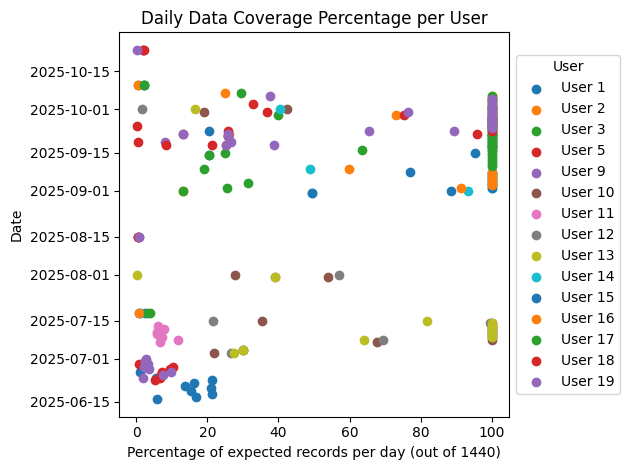

In [14]:
# Load processed dataframe
df = pd.read_csv("HUAMI_EXTENDED_ACTIVITY_SAMPLE_with_datetime.csv")

# Drop rows with missing USER_ID
df = df[df["USER_ID"].notna()]
df = df[df["USER_ID"].astype(str).str.strip() != ""]

# Create user_n (integer user id)
df["user_n"] = df["USER_ID"].astype(str).str.split(".").str[0].astype(int)

# Ensure datetime & date exist
df["datetime"] = pd.to_datetime(df["datetime"], utc=True)
df["date"] = df["datetime"].dt.date

# Count records per user per day
records_per_user_per_day = (
    df
    .groupby(["user_n", "date"])
    .size()
    .reset_index(name="num_records")
)

# Percentage coverage (1440 expected samples per day)
records_per_user_per_day["percentage"] = (
    records_per_user_per_day["num_records"] / 1440 * 100
)

# -------- Plot --------
plt.figure()

for user in records_per_user_per_day["user_n"].unique():
    subset = records_per_user_per_day[
        records_per_user_per_day["user_n"] == user
    ]
    plt.scatter(
        subset["percentage"],
        subset["date"],
        label=f"User {user}"
    )

plt.xlabel("Percentage of expected records per day (out of 1440)")
plt.ylabel("Date")
plt.title("Daily Data Coverage Percentage per User")
plt.legend(title="User",loc="center left",bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


For health data interpolation on very small level is plausible. Above graph gives an insight that records available for each day are quite limited. Important to see coverage of the data

In [15]:
# 1) Define coverage brackets
bins = [0, 50, 60, 70, 80, 90, 100]
labels = [
    "0–50%",
    "51–60%",
    "61–70%",
    "71–80%",
    "81–90%",
    "91–100%"
]

# 2) Assign each day to a bracket
records_per_user_per_day["coverage_bracket"] = pd.cut(
    records_per_user_per_day["percentage"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

# 3) Count number of days per bracket
bracket_counts = (
    records_per_user_per_day
    .groupby("coverage_bracket")
    .size()
    .reset_index(name="num_days")
)

# 4) Print result
print("Number of days in each data coverage bracket:\n")
print(bracket_counts)


Number of days in each data coverage bracket:

  coverage_bracket  num_days
0            0–50%       105
1           51–60%         3
2           61–70%         5
3           71–80%         4
4           81–90%         3
5          91–100%       123


/tmp/ipython-input-912592382.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("coverage_bracket")


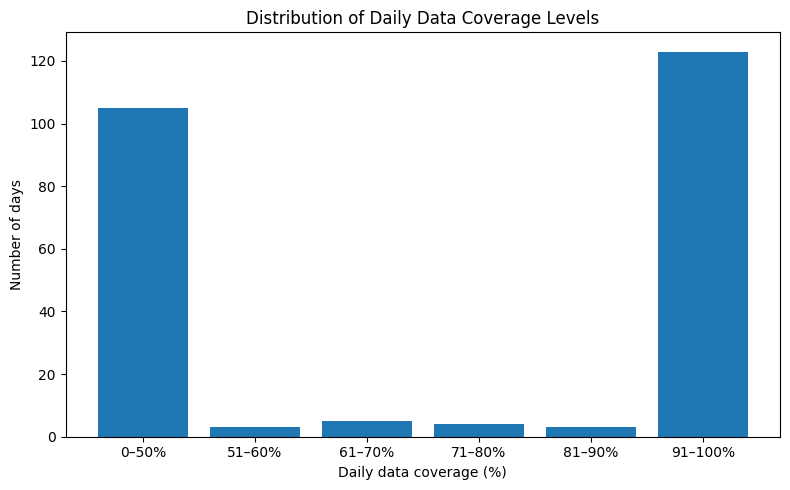

In [24]:
# Ensure correct order of brackets
order = ["0–50%", "51–60%", "61–70%", "71–80%", "81–90%", "91–100%"]
bracket_counts["coverage_bracket"] = bracket_counts["coverage_bracket"].astype(str)

bracket_counts = (
    bracket_counts
    .set_index("coverage_bracket")
    .reindex(order)
    .reset_index()
)

# Bar chart
plt.figure(figsize=(8, 5))
plt.bar(
    bracket_counts["coverage_bracket"],
    bracket_counts["num_days"]
)

plt.xlabel("Daily data coverage (%)")
plt.ylabel("Number of days")
plt.title("Distribution of Daily Data Coverage Levels")
plt.tight_layout()
plt.show()


Based on the above analysis we only have the 91-100% bracked to focus on as that would require the least amount of missing value handling

In [16]:
# 1) Keep only days with 91–100% coverage
good_days = records_per_user_per_day[
    (records_per_user_per_day["percentage"] > 90) & (records_per_user_per_day["percentage"] <= 100)
].copy()

print(f"Total good days (91–100%): {len(good_days)}")

# 2) Count how many good days each user has
good_days_per_user = (
    good_days
    .groupby("user_n")
    .size()
    .reset_index(name="num_good_days")
    .sort_values("num_good_days", ascending=False)
)

print("\nGood days (91–100%) per user:\n")
print(good_days_per_user)

# 3) Filter the original df to ONLY records from those good days
# Keep only the keys (user_n, date) and merge to filter
good_keys = good_days[["user_n", "date"]].drop_duplicates()

df_good = df.merge(good_keys, on=["user_n", "date"], how="inner")

print("\nFiltered dataframe shape (only 91–100% days):", df_good.shape)
print(df_good.head())

Total good days (91–100%): 123

Good days (91–100%) per user:

    user_n  num_good_days
11      17             27
2        3             12
13      19             12
8       14              8
12      18              8
0        1              8
10      16              7
1        2              7
5       10              7
4        9              6
6       12              6
9       15              6
7       13              6
3        5              3

Filtered dataframe shape (only 91–100% days): (176763, 15)
    TIMESTAMP  DEVICE_ID  USER_ID  RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE  \
0  1751932800          7     10.0              0      0       120          63   
1  1751932860          7     10.0              0      0       120          70   
2  1751932920          7     10.0              0      0       120          64   
3  1751932980          7     10.0              0      0       120          66   
4  1751933040          7     10.0             11      0       120          72   



Focussing only on the 123 days in the 91-100% coverage for a better analysis. To see how many sleep activations we have for each user with all records

In [17]:
output_path = "Good_days.csv"
df_good.to_csv(output_path, index=False)

In [18]:
# 1) For each (user_n, date), check if ALL records are sleep > 0
day_sleep_flags = (
    df_good
    .groupby(["user_n", "date"])["SLEEP"]
    .apply(lambda s: (s > 0).all())   # True if every record in the day is sleep>0
    .reset_index(name="all_sleep_gt0")
)

# 2) Split into the two buckets
all_sleep_days = day_sleep_flags[day_sleep_flags["all_sleep_gt0"] == True]
mixed_days     = day_sleep_flags[day_sleep_flags["all_sleep_gt0"] == False]  # means at least one SLEEP==0

# 3) Print totals
print("GOOD days split by SLEEP condition:")
print(f"1) Days where ALL records have SLEEP > 0: {len(all_sleep_days)}")
print(f"2) Days where AT LEAST ONE record has SLEEP == 0: {len(mixed_days)}")

# Optional: print per-user counts (often very useful)
per_user_split = (
    day_sleep_flags
    .groupby(["user_n", "all_sleep_gt0"])
    .size()
    .reset_index(name="num_days")
    .sort_values(["user_n", "all_sleep_gt0"], ascending=[True, False])
)

print("\nPer-user breakdown (all_sleep_gt0=True means ALL SLEEP>0):")
print(per_user_split)


GOOD days split by SLEEP condition:
1) Days where ALL records have SLEEP > 0: 118
2) Days where AT LEAST ONE record has SLEEP == 0: 5

Per-user breakdown (all_sleep_gt0=True means ALL SLEEP>0):
    user_n  all_sleep_gt0  num_days
1        1           True         7
0        1          False         1
2        2           True         7
3        3           True        12
4        5           True         3
5        9           True         6
6       10           True         7
8       12           True         5
7       12          False         1
9       13           True         6
11      14           True         7
10      14          False         1
12      15           True         6
14      16           True         6
13      16          False         1
15      17           True        27
17      18           True         7
16      18          False         1
18      19           True        12


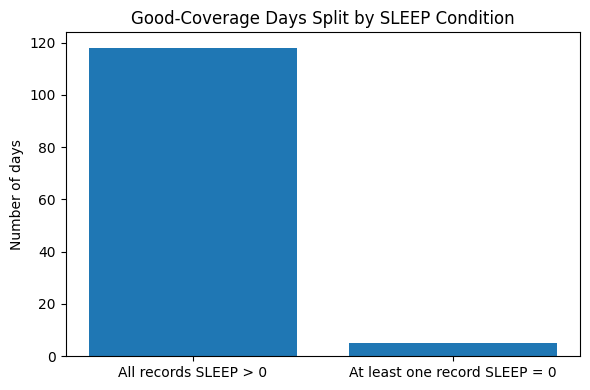

In [26]:
num_all_sleep_days = len(all_sleep_days)
num_mixed_days = len(mixed_days)

# Data for plotting
labels = [
    "All records SLEEP > 0",
    "At least one record SLEEP = 0"
]
values = [
    num_all_sleep_days,
    num_mixed_days
]

# Bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, values)

plt.ylabel("Number of days")
plt.title("Good-Coverage Days Split by SLEEP Condition")
plt.tight_layout()
plt.show()


With the above information out of 123, 118 days are completely marked as sleep meaning 24 hours of sleeping data. Handling false activations is out of scope

   user_n  mixed_days  mixed_days_with_gt1_episode  \
0       1           1                            1   
1      12           1                            1   
2      14           1                            1   
3      16           1                            1   
4      18           1                            1   

   total_sleep_minutes_across_mixed_days  
0                                   1370  
1                                   1431  
2                                   1340  
3                                   1313  
4                                   1376  


/tmp/ipython-input-725270524.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mixed.groupby(["user_n", "date"])["is_sleep"].shift(1).fillna(False)


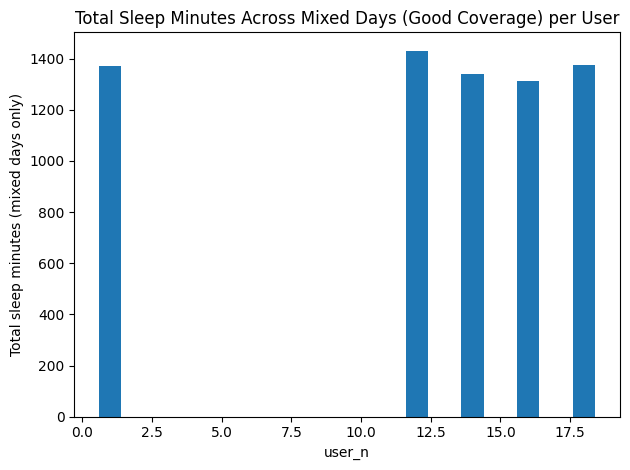

In [21]:

day_sleep_flags = (
    df_good.groupby(["user_n", "date"])["SLEEP"]
    .apply(lambda s: (s > 0).all())
    .reset_index(name="all_sleep_gt0")
)

mixed_keys = day_sleep_flags[day_sleep_flags["all_sleep_gt0"] == False][["user_n", "date"]]
df_mixed = df_good.merge(mixed_keys, on=["user_n", "date"], how="inner")

# Ensure proper ordering within each user/day (use datetime if you have it, else TIMESTAMP)
sort_col = "datetime" if "datetime" in df_mixed.columns else "TIMESTAMP"
df_mixed = df_mixed.sort_values(["user_n", "date", sort_col])

# -----------------------------
# 2) Build sleep episodes within each (user_n, date)
#    Episode = consecutive rows where SLEEP > 0
# -----------------------------
df_mixed["is_sleep"] = df_mixed["SLEEP"] > 0

# episode starts when we are in sleep AND previous row is not sleep (within the same user/day)
df_mixed["prev_is_sleep"] = (
    df_mixed.groupby(["user_n", "date"])["is_sleep"].shift(1).fillna(False)
)
df_mixed["episode_start"] = df_mixed["is_sleep"] & (~df_mixed["prev_is_sleep"])

# cumulative count of episode starts = episode id (only meaningful during sleep rows)
df_mixed["episode_id"] = (
    df_mixed.groupby(["user_n", "date"])["episode_start"].cumsum()
)
# keep only sleep rows for episode stats
sleep_rows = df_mixed[df_mixed["is_sleep"]].copy()

# Each row ~ 1 minute => episode duration (minutes) = number of rows in that episode
episode_summary = (
    sleep_rows.groupby(["user_n", "date", "episode_id"])
    .size()
    .reset_index(name="sleep_minutes_in_episode")
)

day_episode_stats = (
    episode_summary.groupby(["user_n", "date"])
    .agg(
        num_sleep_episodes=("episode_id", "nunique"),
        total_sleep_minutes=("sleep_minutes_in_episode", "sum")
    )
    .reset_index()
)

days_with_gt1_episode = day_episode_stats[day_episode_stats["num_sleep_episodes"] > 1]

per_user_stats = (
    day_episode_stats.groupby("user_n")
    .agg(
        mixed_days=("date", "nunique"),
        mixed_days_with_gt1_episode=("num_sleep_episodes", lambda x: (x > 1).sum()),
        total_sleep_minutes_across_mixed_days=("total_sleep_minutes", "sum")
    )
    .reset_index()
    .sort_values("user_n")
)

print(per_user_stats)

plt.figure()
plt.bar(per_user_stats["user_n"], per_user_stats["total_sleep_minutes_across_mixed_days"])
plt.xlabel("user_n")
plt.ylabel("Total sleep minutes (mixed days only)")
plt.title("Total Sleep Minutes Across Mixed Days (Good Coverage) per User")
plt.tight_layout()
plt.show()


The rest of the 5 days data also is 90% plus marked as sleep data. Therefore no valid records for any day or user is available to perform any methods

## Summary


Why Analysis performance is not possible on this dataset:
1. Deep sleep and REM sleep values are not accurate and they occur simultaneously. It is not valid to be in both sleep states together
2. Out of the total records only 123 days data had 90-100% coverage in terms of episodes.
3. Out of the 123 118 had false activations of sleep causing them to be 100% in sleep state meaning 24 hours of sleep.
4. The remaining 5 values(also almost 100%) were just different users but without sub values and low presence of heart rate values(mostly 255), applying methods was not possible